In [119]:
import sys
sys.path.append('../../')
from epydemia.special_events import ChangeState
from epydemia.basedesim import Event
import numpy as np

In [120]:
class RubellaSusceptibleToExposed(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'rubella', 'exposed')
        time = 0.5 + self.simulator.population.diseases['rubella'].stream.exponential(10)
        RubellaExposedToInfected(self.simulator.now() + time,
                                self.simulator, self.idx)


class RubellaSusceptibleToRecovered(ChangeState):

    def do(self):
        time = self.simulator.population.diseases['rubella'].stream.gamma(25, 10)
        self.simulator.population.change_state(self.idx, 'rubella', 'recovered')


class RubellaExposedToInfected(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'rubella',
                                               'infected')
        time = self.simulator.population.diseases['rubella'].stream.exponential(7)
        if self.simulator.population['measles']['states'][self.idx] == self.simulator.population.diseases['measles']['states']['infected']:
            self.simulator.collector.collect('critical', (1, self.simulator.now()))
        RubellaInfectedToRecovered(self.simulator.now() + time,
                                        self.simulator, self.idx)


class RubellaInfectedToRecovered(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'rubella', 'recovered')


class RubellaImportCases(Event):

    def __init__(self, time, simulator, cases=1):
        super().__init__(time, simulator)
        self.time = time
        self.simulator = simulator
        self.cases = cases

    def do(self):
        susceptibles = self.simulator.population.get_state(
            'rubella', 'susceptible')
        idx = self.simulator.population.diseases['rubella'].stream.choice(
            susceptibles, size=self.cases, replace=False)
        self.simulator.population.change_state(idx, 'rubella', 'infected')
        for person in idx:
            time = self.simulator.population.diseases['rubella'].stream.exponential(5)
            RubellaInfectedToRecovered(self.simulator.now() + time,
                                   self.simulator, person)


In [121]:
class MeaslesSusceptibleToExposed(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'measles', 'exposed')
        time = 0.5 + self.simulator.population.diseases['measles'].stream.exponential(8)
        MeaslesExposedToInfected(self.simulator.now() + time,
                                self.simulator, self.idx)


class MeaslesSusceptibleToRecovered(ChangeState):

    def do(self):
        time = self.simulator.population.diseases['measles'].stream.gamma(20, 8)
        self.simulator.population.change_state(self.idx, 'measles', 'recovered')


class MeaslesExposedToInfected(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'measles',
                                               'infected')
        time = self.simulator.population.diseases['measles'].stream.exponential(8)
        if self.simulator.population['rubella']['states'][self.idx] == self.simulator.population.diseases['rubella']['states']['infected']:
            self.simulator.collector.collect('critical', (1, self.simulator.now()))
        MeaslesInfectedToRecovered(self.simulator.now() + time,
                                        self.simulator, self.idx)


class MeaslesInfectedToRecovered(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'measles', 'recovered')


class MeaslesImportCases(Event):

    def __init__(self, time, simulator, cases=1):
        super().__init__(time, simulator)
        self.time = time
        self.simulator = simulator
        self.cases = cases

    def do(self):
        susceptibles = self.simulator.population.get_state(
            'measles', 'susceptible')
        idx = self.simulator.population.diseases['measles'].stream.choice(
            susceptibles, size=self.cases, replace=False)
        self.simulator.population.change_state(idx, 'measles', 'infected')
        for person in idx:
            time = self.simulator.population.diseases['measles'].stream.exponential(7)
            MeaslesInfectedToRecovered(self.simulator.now() + time,
                                   self.simulator, person)

In [122]:
from epydemia.disease import Disease

class Rubella(Disease):

    def __init__(self, simulator, stream, infection_prob,
                 initial_cases, states, **attributes):
        super().__init__('rubella', simulator, stream, infection_prob,
                         states, **attributes)
        self['initial_cases'] = initial_cases


    def initialize(self, population):
        RubellaImportCases(0, self.simulator, self['initial_cases'])

    def infect(self, population):
        susceptibles, probability = population.get_transmission_probabilities(
            'rubella', ['susceptible'], ['infected'])
        exposed = susceptibles[np.where(
            self.stream.random(len(probability)) <= probability)]
        for person in exposed:
            RubellaSusceptibleToExposed(self.simulator.now(),
                                 self.simulator, person)

    def compute_transmission_probabilities(self, population, vertex_seq):
        '''
        Update transmission must consider all interventions
        '''
        # TODO: #1 determine which factors affect transmission (masking, quarantine, vaccination)
        def quarantine(i, j):
            if i+j == 0:
                return 1
            else:
                return 0
        vfunc = np.vectorize(quarantine)
        quarantine_p = vfunc(*population['quarantine'][vertex_seq].T)
        return quarantine_p*self['infection_prob']
    

In [123]:
class Measles(Disease):

    def __init__(self, simulator, stream, infection_prob,
                 initial_cases, states, **attributes):
        super().__init__('measles', simulator, stream, infection_prob,
                         states, **attributes)
        self['initial_cases'] = initial_cases


    def initialize(self, population):
        MeaslesImportCases(0, self.simulator, self['initial_cases'])

    def infect(self, population):
        susceptibles, probability = population.get_transmission_probabilities(
            'measles', ['susceptible'], ['infected'])
        exposed = susceptibles[np.where(
            self.stream.random(len(probability)) <= probability)]
        for person in exposed:
            MeaslesSusceptibleToExposed(self.simulator.now(),
                                 self.simulator, person)

    def compute_transmission_probabilities(self, population, vertex_seq):
        '''
        Update transmission must consider all interventions
        '''
        # TODO: #1 determine which factors affect transmission (masking, quarantine, vaccination)
        def quarantine(i, j):
            if i+j == 0:
                return 1
            else:
                return 0
        vfunc = np.vectorize(quarantine)
        quarantine_p = vfunc(*population['quarantine'][vertex_seq].T)
        return quarantine_p*self['infection_prob']

In [124]:
from epydemia.simulator import Step

class DailyStep(Step):
    ''' Disease progression '''
    STEP_SIZE = 1 # Daily time step

    def __init__(self, time, simulator):
        super().__init__(time, simulator)
        self.time = time
        self.simulator = simulator

    @classmethod
    def initialize(cls, simulator):
        for t in np.arange(0, int(simulator.stop_time)+1, DailyStep.STEP_SIZE):
            DailyStep(t, simulator)

    def do(self):
        if self.simulator.verbose:
            print('New day beginning {}'.format(self.time))
        for _, disease in self.simulator.population.diseases.items():
            disease.infect(self.simulator.population)

        # Stats collections here
        for d in ['measles', 'rubella']:
            for i, name in zip(range(4),
                            ['S', 'E', 'I', 'R']):
                stat = len(
                    np.where(self.simulator.population[d]['states'] == i)[0])
                self.simulator.collector.collect(d+"_"+name, stat)
        self.simulator.collector.collect(
            'quarantine', (self.simulator.population['quarantine'] == 1).sum())
        self.simulator.collector.collect(
            'states', self.simulator.population['rubella']['states'].copy())

In [125]:
class MeaslesExposedToInfected(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'measles', 'infected')
        time = self.simulator.population.diseases['measles'].stream.exponential(8)
        if self.simulator.population['rubella']['states'][self.idx] == self.simulator.population.diseases['rubella']['states']['infected']:
            self.simulator.collector.collect('critical', (1, self.simulator.now()))
        MeaslesInfectedToRecovered(self.simulator.now() + time,
                                        self.simulator, self.idx)
        if self.simulator.population['quarantine_stream'].rand() <= 0.65:
            time = self.simulator.now()+self.simulator.population['quarantine_stream'].uniform(0.5, 2)
            self.simulator.add_intervention(BeginQuarantine, time, idx=self.idx)
            self.simulator.add_intervention(EndQuarantine, time+14, idx=self.idx)

In [126]:
import sys
sys.path.append('../')
import epydemia as epy

#%%
if __name__ == '__main__':
    sim1 = epy.AgentBasedSim(DailyStep)

    # Create population
    pop_size = 10000
    sim1.create_population(
        how='basic',
        population_size=pop_size,
        network_seed=1024)

    # Add attribute
    sim1.population.add_attribute('quarantine', np.zeros(pop_size))
    sim1.population['quarantine_stream'] = epy.Stream(56324)

    # Create layers of network
    sim1.add_layer(layer_name='community', how='barabasi', n=pop_size, m=10)

    # Define disease
    states = {'susceptible': 0,
                    'exposed': 1,
                    'infected': 2,
                    'recovered': 3}
    sim1.add_disease(Rubella,
                    disease_kwargs={'infection_prob': 0.015,
                                    'initial_cases': 5,
                                    'stream': epy.Stream(65347),
                                    'states':states})
    sim1.add_disease(Measles,
                    disease_kwargs={'infection_prob': 0.03,
                                    'initial_cases': 2,
                                    'stream': epy.Stream(3151),
                                    'states':states})

    # Run model
    sim1.run(stop_time=150, verbose=False)  # Streams should be set when running the model


In [127]:
from epydemia.intervention import Intervention

class BeginQuarantine(Intervention):
    '''docstring'''

    def do(self):
        if self.simulator.verbose:
            print('Begin quarantine of agent'.format(self.kwargs['idx']))
        
        self.simulator.population['quarantine'][self.kwargs['idx']] = 1
        self.simulator.population.update_transmission_probabilities(target_vertex_seq=[self.kwargs['idx']])

class EndQuarantine(Intervention):
    '''docstring'''

    def do(self):
        if self.simulator.verbose:
            print('End quarantine of agent'.format(self.kwargs['idx']))
        
        self.simulator.population['quarantine'][self.kwargs['idx']] = 0
        self.simulator.population.update_transmission_probabilities(target_vertex_seq=[self.kwargs['idx']])

In [128]:
class MeaslesExposedToInfected(ChangeState):

    def do(self):
        self.simulator.population.change_state(self.idx, 'measles', 'infected')
        time = self.simulator.population.diseases['measles'].stream.exponential(8)
        if self.simulator.population['rubella']['states'][self.idx] == self.simulator.population.diseases['rubella']['states']['infected']:
            self.simulator.collector.collect('critical', (1, self.simulator.now()))
        MeaslesInfectedToRecovered(self.simulator.now() + time,
                                        self.simulator, self.idx)
        if self.simulator.population['quarantine_stream'].rand() <= 0.90:
            time = self.simulator.now()+self.simulator.population['quarantine_stream'].uniform(0.5, 2)
            self.simulator.add_intervention(BeginQuarantine, time, idx=self.idx)
            self.simulator.add_intervention(EndQuarantine, time+14, idx=self.idx)

In [129]:
import sys
sys.path.append('../')
import epydemia as epy

#%%
if __name__ == '__main__':
    sim2 = epy.AgentBasedSim(DailyStep)

    # Create population
    pop_size = 10000
    sim2.create_population(
        how='basic',
        population_size=pop_size,
        network_seed=1024)

    # Add attribute
    sim2.population.add_attribute('quarantine', np.zeros(pop_size))
    sim2.population['quarantine_stream'] = epy.Stream(56324)

    # Create layers of network
    sim2.add_layer(layer_name='community', how='barabasi', n=pop_size, m=10)

    # Define disease
    states = {'susceptible': 0,
                    'exposed': 1,
                    'infected': 2,
                    'recovered': 3}
    sim2.add_disease(Rubella,
                    disease_kwargs={'infection_prob': 0.015,
                                    'initial_cases': 5,
                                    'stream': epy.Stream(65347),
                                    'states':states})
    sim2.add_disease(Measles,
                    disease_kwargs={'infection_prob': 0.03,
                                    'initial_cases': 2,
                                    'stream': epy.Stream(3151),
                                    'states':states})

    # Run model
    sim2.run(stop_time=150, verbose=False)  # Streams should be set when running the model

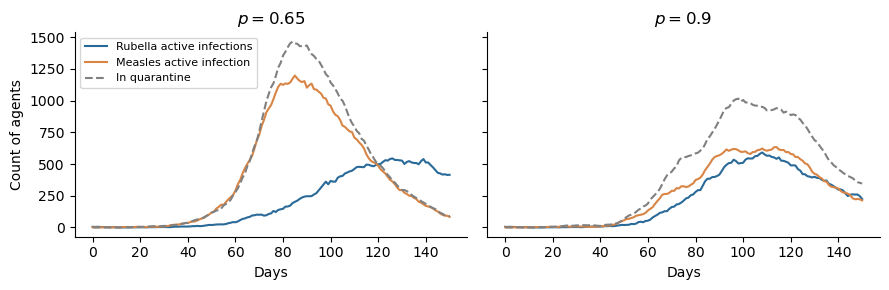

In [143]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
ax.plot(sim1.collector['rubella_I'], label='Rubella active infections', color='#2a6a99')
ax.plot(sim1.collector['measles_I'], label='Measles active infection', color='#d88546')
ax.set_ylabel('Count of agents')
ax.plot(sim1.collector['quarantine'], color='gray', ls='--', label='In quarantine')
ax.spines[['top', 'right']].set_visible(False)
ax.legend(fontsize=8)
ax.set_xlabel('Days')
ax.set_title(r'$p=0.65$')

ax1.plot(sim2.collector['rubella_I'], label='Rubella active infections', color='#2a6a99')
ax1.plot(sim2.collector['measles_I'], label='Measles active infection', color='#d88546')
ax1.plot(sim2.collector['quarantine'], color='gray', ls='--', label='In quarantine')
ax1.spines[['top', 'right']].set_visible(False)
ax1.set_xlabel('Days')
ax1.set_ylim(ax.get_ylim())
plt.tight_layout()
ax1.set_title(r'$p=0.9$')
plt.show()